In [13]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
import pickle

import re

# Import Data

In [15]:
data = pd.read_csv('train_preprocess.tsv.txt', sep='\t',header = None)
df = data.rename(columns={0: 'text', 1: 'label'})
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


# CLEANSING DATA

In [17]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')

df_baru['text'] = df_baru['text'].replace('\n', ' ').str.lower()

def fun(x):
    y = re.sub(r'[^a-zA-Z0-9. ]', '', x)
    return y

df_baru['text_new'] = df_baru['text'].apply(lambda x : fun(x))

df_baru['text_new'] = df_baru['text_new'].replace('   ', ' ')
df_baru['text_new'] = df_baru['text_new'].replace('  ', ' ')



df_baru.head()

,text,negative,neutral,positive,text_new
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,0,1,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,1,0,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,0,0,1,lokasi strategis di jalan sumatera bandung . t...
3,betapa bahagia nya diri ini saat unboxing pake...,0,0,1,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,1,0,0,duh . jadi mahasiswa jangan sombong dong . kas...


# PENAMAAN VARIABEL X DAN Y

In [19]:
x = df_baru['text_new'].values
y = df_baru[['negative', 'neutral', 'positive']].values

In [20]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x)
sekuens_x = tokenizer.texts_to_sequences(x)
padded_x = pad_sequences(sekuens_x)

In [21]:
pickle.dump(tokenizer, open("feature_New_lstm.sav", "wb"))

In [68]:
y = df.label

# SPLIT TRAIN , VALIDATION AND TEST 

In [23]:
x_train, x_test, y_train, y_test = train_test_split(padded_x, y, test_size=0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

# MODEL LSTM

In [25]:
%%time

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=100000, output_dim=128),
    tf.keras.layers.LSTM(32, dropout=0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.9 ):
            self.model.stop_training = True

callbacks = myCallback()

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

num_epochs = 5
history = model.fit(x_train, 
                y_train, 
                batch_size = 16,
                epochs=num_epochs, 
                validation_data=(x_val, y_val),     
                callbacks = [callbacks]
)

Epoch 1/5
440/440 ━━━━━━━━━━━━━━━━━━━━ 69s 141ms/step - categorical_accuracy: 0.7325 - loss: 0.6915 - val_categorical_accuracy: 0.8795 - val_loss: 0.3281
Epoch 2/5
440/440 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - categorical_accuracy: 0.9097 - loss: 0.2594 - val_categorical_accuracy: 0.8830 - val_loss: 0.3038
Epoch 3/5
440/440 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - categorical_accuracy: 0.9432 - loss: 0.1690 - val_categorical_accuracy: 0.8705 - val_loss: 0.3553
Epoch 4/5
440/440 ━━━━━━━━━━━━━━━━━━━━ 84s 140ms/step - categorical_accuracy: 0.9626 - loss: 0.1119 - val_categorical_accuracy: 0.8807 - val_loss: 0.3757
Epoch 5/5
440/440 ━━━━━━━━━━━━━━━━━━━━ 61s 139ms/step - categorical_accuracy: 0.9739 - loss: 0.0740 - val_categorical_accuracy: 0.8619 - val_loss: 0.4256
CPU times: total: 16min 6s
Wall time: 5min 54s


In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (16, 95, 128)               │      12,800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (16, 32)                    │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (16, 8)                     │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (16, 3)                     │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,462,699 (146.72 MB)

 Trainable params: 12,820,899 (48.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,641,800 (97.82 MB)

In [40]:
y_pred_test = model.predict(x_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


In [75]:
# menghitung nilai f1
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn import metrics

In [77]:
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

Testing selesai
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       680
           1       0.89      0.71      0.79       239
           2       0.89      0.92      0.90      1281

    accuracy                           0.86      2200
   macro avg       0.86      0.81      0.83      2200
weighted avg       0.86      0.86      0.86      2200



In [54]:
pickle.dump(model, open("model_lstm.sav", 'wb'))

# ACCURACY

In [56]:
train_loss, train_acc = model.evaluate(x_train, y_train)
val_loss, val_acc = model.evaluate(x_val, y_val)
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - categorical_accuracy: 0.9791 - loss: 0.0583
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.8858 - loss: 0.3596
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.8667 - loss: 0.4418

Train: 0.981, val: 0.872, test: 0.859,


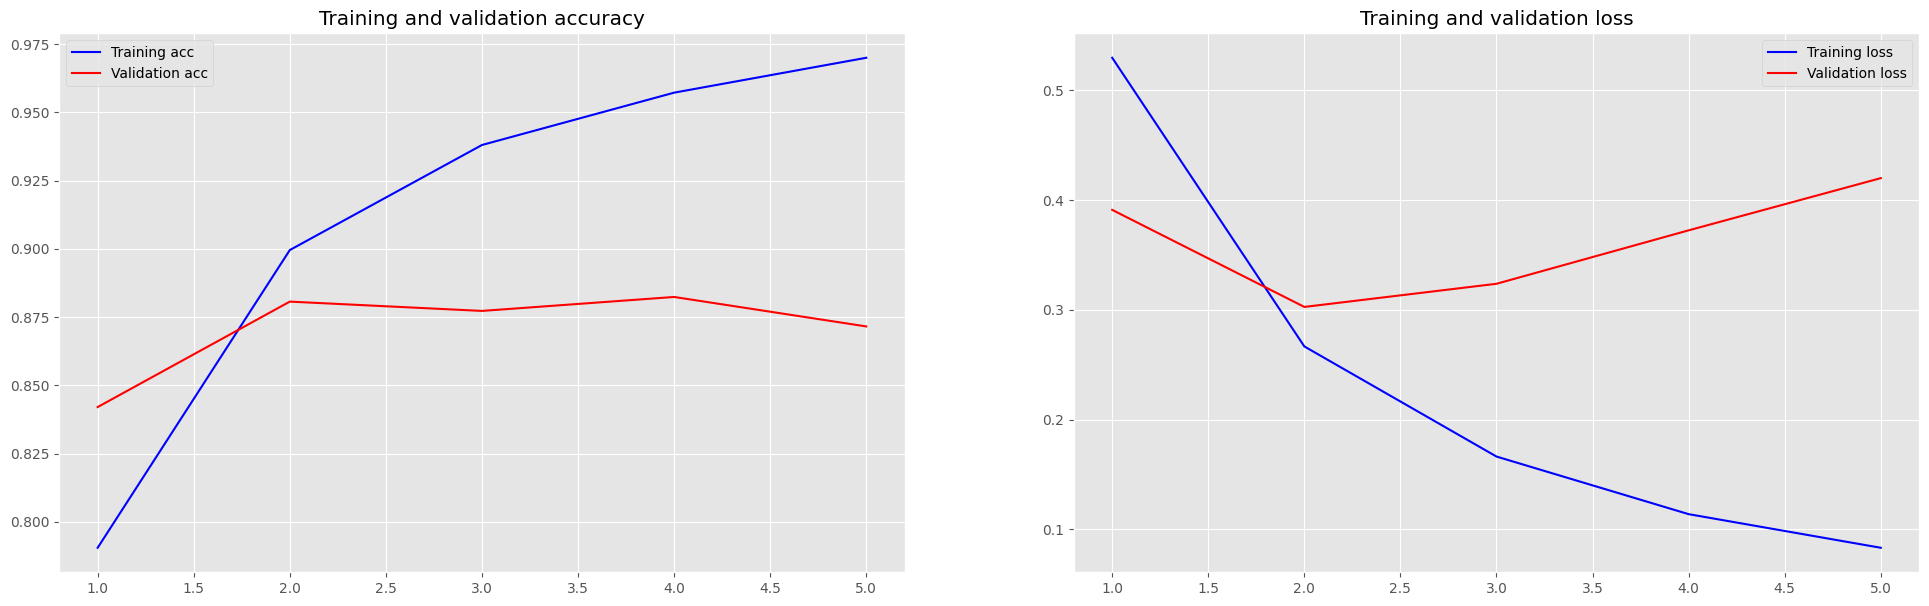

In [57]:
# Visualize it
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)